In [1]:
import os
os.environ['NETKET_EXPERIMENTAL_SHARDING'] = '1'
os.environ['NETKET_EXPERIMENTAL_FFT_AUTOCORRELATION'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6,7"

In [2]:
import netket as nk

import sys
# sys.path.append('/scratch/samiz/Vscore_ThermodynamicLimit_Analysis/AFM_VMC')
sys.path.append('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/AFM_VMC')

import jax.numpy as jnp
import matplotlib.pyplot as plt

import flax.linen as nn
from typing import Any
from netket.jax import logsumexp_cplx

from Afm_Model_functions import *
from vmc_2spins_sampler import *
from Spin_Observables import *
import pickle
import ViT_2d_Vers5 as vit
from data_extracter import *
import os
from jax import vmap

In [3]:
L = 10
TriGraph = nk.graph.Triangular(extent = [L,L], pbc = True)

pHa = {
    'L': L,
    'J1' : 1.0,
    'J2' : 0.4375,
    'Dxy': 0.75,
    'd' : 0.1,
    'dprime' : 0.5,
    'sublattice': [0,1,2,3,4,5,6,7,8,9,
                   20,21,22,23,24,25,26,27,28,29,
                   40,41,42,43,44,45,46,47,48,49,
                   60,61,62,63,64,65,66,67,68,69,
                   80,81,82,83,84,85,86,87,88,89]
}

Ha, hi2d = H_afmJ123(L=pHa['L'], J1=pHa['J1'], J2=pHa['J2'], J3=pHa['J2'], Dxy=pHa['Dxy'], d=pHa['d'], dprime=pHa['dprime'], return_space=True,
                        parity=0., sublattice = pHa['sublattice'], make_rotation=True, exchange_XY=True)


XX = Exchange_OP(hi2d, TriGraph).to_jax_operator()
sa_Ha = nk.sampler.MetropolisHamiltonian(hilbert=hi2d, hamiltonian=XX, n_chains=32, sweep_size = 3* hi2d.size)
sa_ex = nk.sampler.MetropolisExchange(hilbert=hi2d, graph=TriGraph, n_chains=32, sweep_size=3*hi2d.size)
rules5050 = nk.sampler.rules.MultipleRules(rules = [sa_Ha.rule, sa_ex.rule], probabilities = [0.5, 0.5])
sa_HaEx5050 = nk.sampler.MetropolisSampler(hi2d, rules5050, n_chains=64, sweep_size=3*hi2d.size)


In [4]:
def Sz_tot(graph, hilbert):
    """
    input:
    graph: (netket.graph) the graph of the system
    hilbert: (netket.hilbert) the hilbert space of the system

    return:
    the total Sz operator
    """
    Sz = 0.0
    Ntot = graph.n_nodes
    for i in range(Ntot):
        Sz += sigmaz(hilbert, i)
    return Sz/Ntot

Mtot = Sz_tot(nk.graph.Triangular(extent=[L,L], pbc=True), hi2d)

In [5]:
pVit = {
    'd': 32,
    'h': 8,
    'nl': 1,
    'Dtype': jnp.float64,
    'hidden_density': 1,
    'L': L,
    'Cx': 5,
    'Cy': 2,
    'patch_arr': HashableArray(jnp.array([[0,1,10,11,20,21,30,31,40,41], [2,3,12,13,22,23,32,33,42,43],
                                         [4,5,14,15,24,25,34,35,44,45], [6,7,16,17,26,27,36,37,46,47],
                                         [8,9,18,19,28,29,38,39,48,49], [50,51,60,61,70,71,80,81,90,91], 
                                         [52,53,62,63,72,73,82,83,92,93], [54,55,64,65,74,75,84,85,94,95], 
                                         [56,57,66,67,76,77,86,87,96,97], [58,59,68,69,78,79,88,89,98,99],
                                         ]))
    }

patch_transl = HashableArray(vit.get_translation(L, L, L**2, pVit['Cx'], pVit['Cy']))

m_Vit = vit.Vit_2d_full_symm(patch_arr=HashableArray(pVit['patch_arr']), embed_dim=pVit['d'], num_heads=pVit['h'], nl=pVit['nl'],
                                Dtype=pVit['Dtype'], L=pVit['L'], Cx=pVit['Cx'], Cy=pVit['Cy'], hidden_density=pVit['hidden_density'],
                                recover_full_transl_symm=True, translations = patch_transl, recover_spin_flip_symm=True)

In [7]:
vs_vit = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_Vit, n_samples=2**12, n_discard_per_chain=16)

In [8]:
with open('patching_xy52_signstructure/Log_Files/log_vit_sampler_HaEx_5050_transflip.pickle', 'rb') as f:
    vs_vit.variables = pickle.load(f)


In [10]:
pVit_deep = {
    'd': 32,
    'h': 8,
    'nl': 6,
    'Dtype': jnp.float64,
    'hidden_density': 1,
    'L': L,
    'Cx': 5,
    'Cy': 2,
    'patch_arr': HashableArray(jnp.array([[0,1,10,11,20,21,30,31,40,41], [2,3,12,13,22,23,32,33,42,43],
                                         [4,5,14,15,24,25,34,35,44,45], [6,7,16,17,26,27,36,37,46,47],
                                         [8,9,18,19,28,29,38,39,48,49], [50,51,60,61,70,71,80,81,90,91], 
                                         [52,53,62,63,72,73,82,83,92,93], [54,55,64,65,74,75,84,85,94,95], 
                                         [56,57,66,67,76,77,86,87,96,97], [58,59,68,69,78,79,88,89,98,99],
                                         ]))
}

patch_transl = HashableArray(vit.get_translation(L, L, L**2, pVit['Cx'], pVit['Cy']))

m_Vit_deep = vit.Vit_2d_full_symm(patch_arr=HashableArray(pVit_deep['patch_arr']), embed_dim=pVit_deep['d'], num_heads=pVit_deep['h'], nl=pVit_deep['nl'],
                                Dtype=pVit_deep['Dtype'], L=pVit_deep['L'], Cx=pVit_deep['Cx'], Cy=pVit_deep['Cy'], hidden_density=pVit_deep['hidden_density'],
                                recover_full_transl_symm=True, translations = patch_transl, recover_spin_flip_symm=True)

vs_vit_nl6 = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_Vit_deep, n_samples=2**12, n_discard_per_chain=16)
print(vs_vit_nl6.n_parameters)

35696


In [11]:
with open('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/10x10_ViT_RBM_Refined_Learning/patching_xy52_signstructure_nl_6/Log_Files/log_vit_sampler_HaEx_5050_transflip.pickle', 'rb') as handle:
    vs_vit_nl6.variables = pickle.load(handle)

In [9]:
lattice_trans = get_lattice_transls(L**2, L, L)
m_rbm = rbm_trans_flip(translations=HashableArray(lattice_trans), alpha=1, param_dtype=complex)
m_rbm2 = rbm_trans_flip(translations=HashableArray(lattice_trans), alpha=2, param_dtype=complex)

vs_rbm1_SS = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_rbm, n_samples=2**12, n_discard_per_chain=16)
vs_rbm2_SS = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_rbm2, n_samples=2**12, n_discard_per_chain=16)

with open('10x10_XYZ_RBM/Log_Files/log_saHaEx5050_rbm_alpha1.0_transflip_SS.pickle', 'rb') as f:
    vs_rbm1_SS.variables = pickle.load(f)

with open('10x10_XYZ_RBM/Log_Files/log_saHaEx5050_rbm_alpha2.0_transflip_SS.pickle', 'rb') as f:
    vs_rbm2_SS.variables = pickle.load(f)

### Plot Energy and Vscore for rbm and vit

In [10]:
path_vit52 = 'patching_xy52_signstructure/Log_Files'
path_rbm = '10x10_XYZ_RBM/Log_Files'

data = {}
extract_data([f for f in os.listdir(path_vit52) if '.log' in f], data, path_vit52, ['log_vit_sampler_HaEx_5050'], ['vit52'], L=10)
extract_data([f for f in os.listdir(path_rbm) if '.log' in f], data, path_rbm, ['log_saHaEx5050_'], [''], L=10)

In [10]:
data.keys()

dict_keys(['vit52', 'vit52_transflip', 'rbm_alpha2.0_SS', 'rbm_alpha1.0_SS', 'rbm_alpha2.0_transflip_SS', 'rbm_alpha1.0_transflip_SS'])

/tmp/ipykernel_3877877/1859950921.py:24: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1)


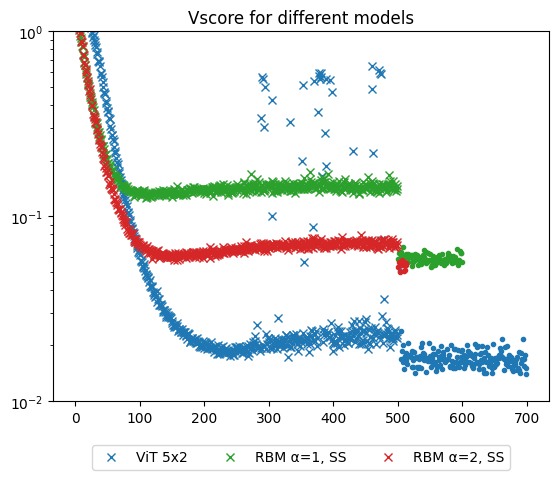

In [11]:
plt.figure()
plt.title('Vscore for different models')

step1 = len(data['vit52']['Vscore'])
plt.semilogy(data['vit52']['Vscore'], marker='x', linestyle='', label='ViT 5x2', color='tab:blue')
step2 = len(data['vit52_transflip']['Vscore'])
plt.semilogy(step1 + jnp.arange(0, step2), data['vit52_transflip']['Vscore'], marker='.', linestyle='', color='tab:blue')


step1 = len(data['rbm_alpha1.0_SS']['Vscore'])
plt.semilogy(data['rbm_alpha1.0_SS']['Vscore'], marker='x', linestyle='', label='RBM α=1, SS', color='tab:green')
step2 = len(data['rbm_alpha1.0_transflip_SS']['Vscore'])
plt.semilogy(step1 + jnp.arange(0, step2), data['rbm_alpha1.0_transflip_SS']['Vscore'], marker='.', linestyle='', color='tab:green')

step1 = len(data['rbm_alpha2.0_SS']['Vscore'])
plt.semilogy(data['rbm_alpha2.0_SS']['Vscore'], marker='x', linestyle='', label='RBM α=2, SS', color='tab:red')
step2 = len(data['rbm_alpha2.0_transflip_SS']['Vscore'])
plt.semilogy(step1 + jnp.arange(0, step2), data['rbm_alpha2.0_transflip_SS']['Vscore'], marker='.', linestyle='', color='tab:red')



plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

plt.ylim(0,1)
plt.show()



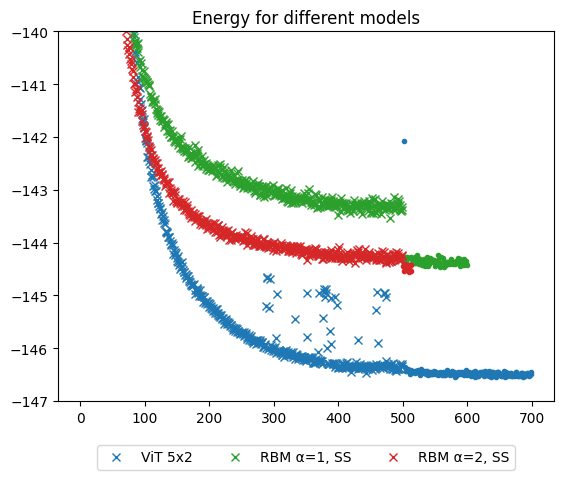

In [12]:
plt.figure()
plt.title('Energy for different models')

step1 = len(data['vit52']['Energy'])
plt.plot(data['vit52']['Energy'], marker='x', linestyle='', label='ViT 5x2', color='tab:blue')
step2 = len(data['vit52_transflip']['Energy'])
plt.plot(step1 + jnp.arange(0, step2), data['vit52_transflip']['Energy'], marker='.', linestyle='', color='tab:blue')


step1 = len(data['rbm_alpha1.0_SS']['Energy'])
plt.plot(data['rbm_alpha1.0_SS']['Energy'], marker='x', linestyle='', label='RBM α=1, SS', color='tab:green')
step2 = len(data['rbm_alpha1.0_transflip_SS']['Energy'])
plt.plot(step1 + jnp.arange(0, step2), data['rbm_alpha1.0_transflip_SS']['Energy'], marker='.', linestyle='', color='tab:green')

step1 = len(data['rbm_alpha2.0_SS']['Energy'])
plt.plot(data['rbm_alpha2.0_SS']['Energy'], marker='x', linestyle='', label='RBM α=2, SS', color='tab:red')
step2 = len(data['rbm_alpha2.0_transflip_SS']['Energy'])
plt.plot(step1 + jnp.arange(0, step2), data['rbm_alpha2.0_transflip_SS']['Energy'], marker='.', linestyle='', color='tab:red')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

plt.ylim(-147, -140)
plt.show()


### Compute expected magnetization and energy as well as spin spin correlation as well as spin structure factor

In [16]:
print(data['vit52_transflip']['Energy'][-1], data['vit52_transflip']['Variance'][-1], data['vit52_transflip']['Vscore'][-1])
print(data['rbm_alpha1.0_transflip_SS']['Energy'][-1], data['rbm_alpha1.0_transflip_SS']['Variance'][-1], data['rbm_alpha1.0_transflip_SS']['Vscore'][-1])


-146.48003214979292 3.239641571780668 0.01509851310752977
-144.41527215371943 11.852733606084279 0.05683112629006541


In [17]:
print(vs_vit.expect(Mtot.to_jax_operator()), vs_rbm1_SS.expect(Mtot.to_jax_operator()), vs_rbm2_SS.expect(Mtot.to_jax_operator()))

-0.0000+0.0000j ± 0.0011 [σ²=0.0029, R̂=1.0134, τ=0.8<2.7] 0.00104+0.00000j ± 0.00066 [σ²=0.00192, R̂=1.0067, τ=0.9<2.3] -0.00013+0.00000j ± 0.00072 [σ²=0.00181, R̂=1.0093, τ=0.7<2.9]


In [13]:
SpinSpin_Corrs = {}
SpinSpin_Corrs_Err = {}

def compute_spin_spin_corr(vs, label, make_rotate=False, sublattice=None):
    values = []
    errors = []
    for j in range(1, hi2d.size):
        op = SpinSpin(0, j, hi2d, make_rotation=make_rotate, sublattice=sublattice).to_jax_operator() / 3
        stats = vs.expect(op)
        values.append(stats.mean)
        errors.append(stats.error_of_mean)
    SpinSpin_Corrs[label] = values
    SpinSpin_Corrs_Err[label] = errors


compute_spin_spin_corr(vs_vit, 'vit52', make_rotate=True, sublattice=pHa['sublattice'])
compute_spin_spin_corr(vs_rbm1_SS, 'rbm1', make_rotate=True, sublattice=pHa['sublattice'])
compute_spin_spin_corr(vs_rbm2_SS, 'rbm2', make_rotate=True, sublattice=pHa['sublattice'])


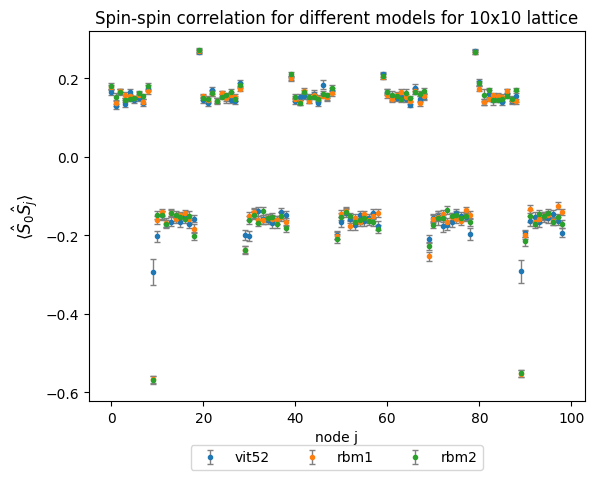

In [14]:
plt.figure()
plt.title('Spin-spin correlation for different models for 10x10 lattice')
plt.ylabel(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$', fontsize=12)
plt.xlabel('node j')
for key in SpinSpin_Corrs.keys():
    # plt.plot(np.real(SpinSpin_Corrs[key]), marker='.', linestyle='', label=key)
    plt.errorbar(y=np.real(SpinSpin_Corrs[key]), x=jnp.arange(0, len(SpinSpin_Corrs[key])), yerr=SpinSpin_Corrs_Err[key], fmt='.', ecolor='gray', elinewidth=1, capsize=2, label=key)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.show()

## Structure Factor

In [13]:
pi = np.pi
nodes = [
    (-4*pi/3, 0),  # Leftmost node
    (-2*pi/3, -2*pi/np.sqrt(3)),  # Bottom left
    (2*pi/3, -2*pi/np.sqrt(3)),  # Bottom right
    (4*pi/3, 0),  # Rightmost node
    (2*pi/3, 2*pi/np.sqrt(3)),  # Top right
    (-2*pi/3, 2*pi/np.sqrt(3)),  # Top left
    (-4*pi/3, 0)  # Close the hexagon by repeating the first node
]

x_coords, y_coords = zip(*nodes)

In [14]:
ks = FourierPoints_In_BrioullinZone(10, 100)

In [21]:
ds = Create_Differences(TriGraph)
sss, ss_err = Create_SpinSpin_Vec(vs_vit,hi2d, TriGraph, make_rotation=True, sublattice=pHa['sublattice'], get_error=True)
# FourierPoints_In_BrioullinZone
Sk_vit52, Sk_errs = vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, sss, hi2d.size, ss_err)


In [29]:
with open('StructureFactor_vit52_SS_values.pickle', 'wb') as f:
    pickle.dump(Sk_vit52, f)
    
with open('StructureFactor_vit52_SS_errors.pickle', 'wb') as f:
    pickle.dump(Sk_errs, f)

In [17]:
with open('StructureFactor_vit52_SS_values.pickle', 'rb') as handle:
    test_values = pickle.load(handle)

In [18]:
print(np.where(np.all(np.isclose(ks , (3.14159, 0.362759)), axis=1)))

print(test_values[298])

(array([298]),)
(5.224093973949614+0.002657871986226654j)


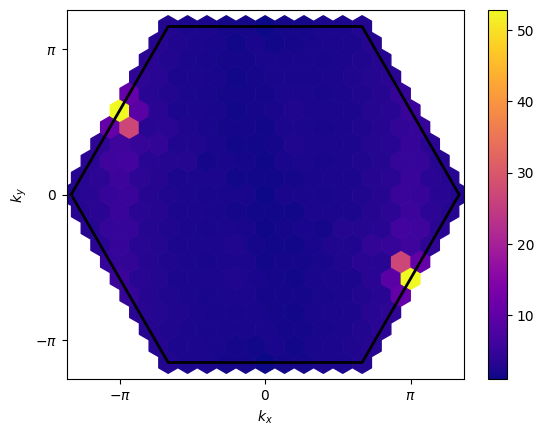

In [19]:
thickness =  24000 / L**2 
plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='')
# plt.scatter(ks[:,0], ks[:,1], c=Sk_vit52.real, cmap='plasma', s=thickness, marker='h')
plt.scatter(ks[:,0], ks[:,1], c=test_values.real, cmap='plasma', s=thickness, marker='h')
# plt.scatter(kx,ky, c=Sk_rbm1.real, cmap='plasma', s=20, marker='o')
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
plt.axis('equal')
# plt.ylim(-np.pi, np.pi)
plt.xlim(-np.pi, np.pi)

plt.show()


In [51]:
np.max(test_values)

Array(52.84747676-0.02129175j, dtype=complex128)

In [20]:
ds = Create_Differences(TriGraph)
ss_rbm, ss_rbm_err = Create_SpinSpin_Vec(vs_rbm2_SS, hi2d, TriGraph, make_rotation=True, sublattice=pHa['sublattice'], get_error=True, sharding=True)
# FourierPoints_In_BrioullinZone
Sk_rbm2, Sk_rbm2_errs = vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, ss_rbm, hi2d.size, ss_rbm_err)

In [21]:
with open('StructureFactor_rbm2_SS_values.pickle', 'wb') as f:
    pickle.dump(Sk_rbm2, f)
with open('StructureFactor_rbm2_SS_errors.pickle', 'wb') as f:
    pickle.dump(Sk_rbm2_errs, f)

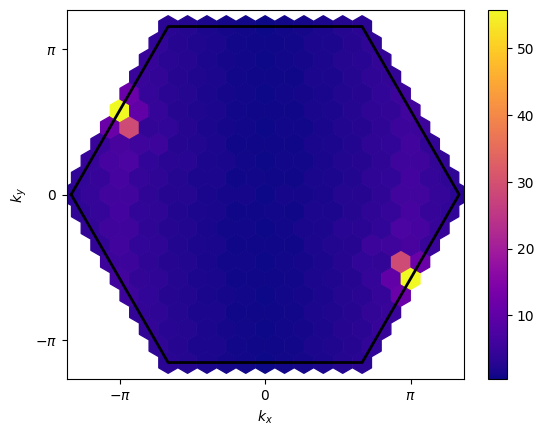

In [22]:
thickness =  24000 / L**2 
plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='')
plt.scatter(ks[:,0], ks[:,1], c=Sk_rbm2.real, cmap='plasma', s=thickness, marker='h')
# plt.scatter(kx,ky, c=Sk_rbm1.real, cmap='plasma', s=20, marker='o')
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
plt.axis('equal')
# plt.ylim(-np.pi, np.pi)
plt.xlim(-np.pi, np.pi)

plt.show()

In [27]:
M_ind = np.where(np.all(np.isclose(ks , (np.pi, np.pi/np.sqrt(3))), axis=1))
Sk_rbm2[M_ind]

Array([5.89123679+0.00033649j], dtype=complex128)

In [28]:
Sk_rbm2[np.where(np.all(np.isclose(ks , (3.14159, 0.362759)), axis=1))]

Array([6.15863579+0.00030619j], dtype=complex128)

In [15]:
ks = FourierPoints_In_BrioullinZone(10, 100)
ds = Create_Differences(TriGraph)
ss_nl6, ss_nl6_err = Create_SpinSpin_Vec(vs_vit_nl6, hi2d, TriGraph, make_rotation=True, sublattice=pHa['sublattice'], get_error=True, sharding=True)
# FourierPoints_In_BrioullinZone
Sk_nl6, Sk_nl6_errs = vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, ss_nl6, hi2d.size, ss_nl6_err)

In [16]:
with open('StructureFactor_vit_SS_nl6.pickle', 'wb') as f:
    pickle.dump(Sk_nl6, f)

with open('StructureFactor_vit_SS_nl6_errors.pickle', 'wb') as f:
    pickle.dump(Sk_nl6_errs, f)

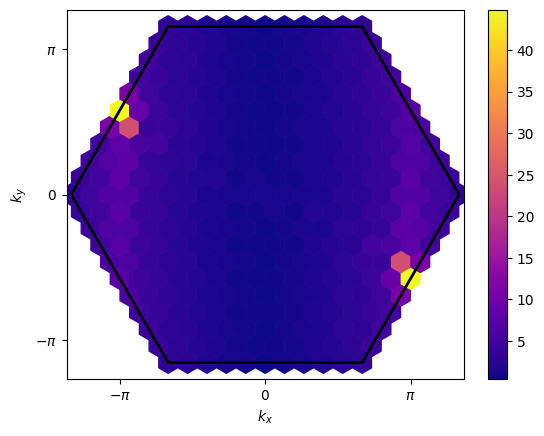

In [17]:
thickness =  24000 / L**2 
plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='')
plt.scatter(ks[:,0], ks[:,1], c=Sk_nl6.real, cmap='plasma', s=thickness, marker='h')
# plt.scatter(kx,ky, c=Sk_rbm1.real, cmap='plasma', s=20, marker='o')
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
plt.axis('equal')
# plt.ylim(-np.pi, np.pi)
plt.xlim(-np.pi, np.pi)

plt.show()

In [25]:
# [ 3.14159265,  0.36275987]
print(Sk_nl6[np.where(np.all(np.isclose(ks , (3.14159, -0.362759)), axis=1))])
print(Sk_nl6_errs[np.where(np.all(np.isclose(ks , (3.14159, -0.362759)), axis=1))])

print(np.max(Sk_nl6))

[7.58052078-0.00124691j]
[0.02805897]
(44.8603479869659+0.005857498045870832j)


## Attention maps

In [40]:
# vs_vit.parameters['ViT_2d_0']['ViT_real_0']['Transformer_Encoder_0']['Self_Attention_2d_0'].keys()
alpha10 = vs_vit.parameters['ViT_2d_0']['ViT_real_0']['Transformer_Encoder_0']['Self_Attention_2d_0']['alpha']
alpha10.shape

(8, 10)

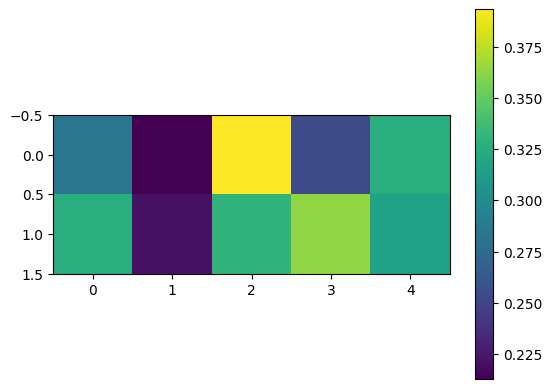

In [45]:
alpha10mean = jnp.mean(jnp.abs(alpha10), axis=0)
plt.imshow(alpha10mean.reshape(2,5), cmap='viridis')
plt.colorbar()